##**ROUND 4**
**Target:** Introduce Scheduler StepLR and check with varying learning rates gradient descent  
**Results:** Gives our desired model.  
  With lr = 0.05 and gamma = 0.03  

             1. Max Train Accuracy : 99.27 
             2. Max Test Accuracy : 99.48  

**Analysis:** Model overfits on increasing the learning rate(from 0.01 - 0.05) while keeping the gradient descent small.    
              Convergence is slow. 

**Import Libraries**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Data Transformations**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**Dataset and Creating Train/Test Split**

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**Dataloader Arguments & Test/Train Dataloaders**

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


**Data Statistics**

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


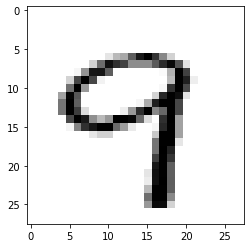

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


**Dataset visualisation for Image Augmentation**

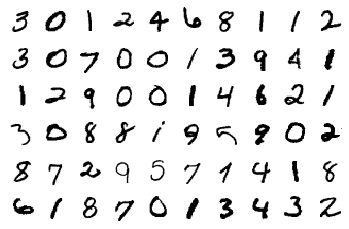

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

##**Round 5 Model**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26  rf = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        ) # output_size = 24  rf = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12 rf = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.10)
        ) # output_size = 12  rf = 10

        # CONVOLUTION BLOCK 2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.10)
        ) # output_size = 10  rf = 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10)
        ) # output_size = 8  rf = 14
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.10)
        ) # output_size = 6  rf = 16

        # OUTPUT BLOCK
        #avgpool
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6))

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(10),  rf = 16
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 10, 12, 12]             160
             ReLU-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
           Conv2d-13           [-1, 10, 10, 10]             900
             ReLU-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=2.318324089050293 Batch_id=1 Accuracy=7.81:   0%|          | 1/938 [00:00<01:37,  9.61it/s] 

EPOCH: 0


Loss=0.08642343431711197 Batch_id=937 Accuracy=90.64: 100%|██████████| 938/938 [01:19<00:00, 11.84it/s]
Loss=0.15613830089569092 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:19, 11.74it/s]


Test set: Average loss: 0.0687, Accuracy: 9802/10000 (98.02%)

EPOCH: 1


Loss=0.02539500594139099 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [01:18<00:00, 13.00it/s]
Loss=0.09911257028579712 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:19, 11.77it/s]


Test set: Average loss: 0.0455, Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.18562377989292145 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [01:18<00:00, 12.92it/s]
Loss=0.06003698706626892 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:21, 11.44it/s]


Test set: Average loss: 0.0632, Accuracy: 9796/10000 (97.96%)

EPOCH: 3


Loss=0.07584524899721146 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:20<00:00, 12.85it/s]
Loss=0.0305575430393219 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:17, 12.06it/s]


Test set: Average loss: 0.0391, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.027470959350466728 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [01:18<00:00, 11.90it/s]
Loss=0.13790182769298553 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:19, 11.79it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.01245155744254589 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [01:17<00:00, 13.09it/s]
Loss=0.0454777255654335 Batch_id=1 Accuracy=96.88:   0%|          | 2/938 [00:00<01:18, 11.96it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.018997270613908768 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [01:17<00:00, 11.29it/s]
Loss=0.050312601029872894 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:18, 11.95it/s]


Test set: Average loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.034448109567165375 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [01:15<00:00, 13.32it/s]
Loss=0.017695460468530655 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:15, 12.40it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.014702657237648964 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:15<00:00, 13.54it/s]
Loss=0.11836306005716324 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:19, 11.75it/s]


Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.007239906117320061 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:16<00:00, 12.80it/s]
Loss=0.08286459743976593 Batch_id=1 Accuracy=97.66:   0%|          | 2/938 [00:00<01:15, 12.47it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.013416455127298832 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:17<00:00, 12.07it/s]
Loss=0.013965239748358727 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:13, 12.66it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.07224073261022568 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:15<00:00, 13.33it/s]
Loss=0.005873165093362331 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:18, 11.88it/s]


Test set: Average loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.006937073078006506 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [01:15<00:00, 13.18it/s]
Loss=0.009537368081510067 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:17, 12.14it/s]


Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.020039590075612068 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:14<00:00, 13.06it/s]
Loss=0.04300744831562042 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:14, 12.54it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.008993213064968586 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:15<00:00, 12.42it/s]
Loss=0.03499208763241768 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:16, 12.19it/s]


Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.007196211721748114 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [01:14<00:00, 12.51it/s]



Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)



In [15]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.3)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=2.320488452911377 Batch_id=1 Accuracy=14.84:   0%|          | 1/938 [00:00<01:39,  9.37it/s] 

EPOCH: 0


Loss=0.0839158147573471 Batch_id=937 Accuracy=94.48: 100%|██████████| 938/938 [01:17<00:00, 12.03it/s]
Loss=0.020845886319875717 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:13, 12.71it/s]


Test set: Average loss: 0.0475, Accuracy: 9856/10000 (98.56%)

EPOCH: 1


Loss=0.1076904907822609 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [01:18<00:00, 12.90it/s]
Loss=0.0047127981670200825 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:25, 10.90it/s]


Test set: Average loss: 0.0359, Accuracy: 9884/10000 (98.84%)

EPOCH: 2


Loss=0.0124583775177598 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [01:19<00:00, 13.25it/s]
Loss=0.01602453738451004 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:19, 11.80it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.01593349315226078 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:19<00:00, 12.73it/s]
Loss=0.07357507944107056 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:14, 12.56it/s]


Test set: Average loss: 0.0344, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.22794616222381592 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [01:19<00:00, 12.90it/s]
Loss=0.029089227318763733 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:20, 11.59it/s]


Test set: Average loss: 0.0250, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.19108086824417114 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:17<00:00, 12.67it/s]
Loss=0.09296728670597076 Batch_id=1 Accuracy=98.44:   0%|          | 2/938 [00:00<01:16, 12.22it/s]


Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.005518285091966391 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:19<00:00, 12.83it/s]
Loss=0.0016391492681577802 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:16, 12.18it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.0034873024560511112 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:18<00:00, 12.61it/s]
Loss=0.005860252771526575 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:18, 11.85it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.0006315914215520024 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [01:17<00:00, 13.03it/s]
Loss=0.00688987597823143 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:15, 12.44it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.1120438426733017 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:17<00:00, 13.03it/s]
Loss=0.03708281368017197 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:20, 11.68it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


Loss=0.06883150339126587 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:18<00:00, 12.84it/s]
Loss=0.008036002516746521 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:17, 12.10it/s]


Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.011403306387364864 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [01:17<00:00, 13.04it/s]
Loss=0.043132148683071136 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:17, 12.13it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.027013547718524933 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [01:17<00:00, 13.08it/s]
Loss=0.002571187913417816 Batch_id=1 Accuracy=99.22:   0%|          | 2/938 [00:00<01:18, 11.90it/s]


Test set: Average loss: 0.0172, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.015925021842122078 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [01:17<00:00, 12.72it/s]
Loss=0.0012839152477681637 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:21, 11.55it/s]


Test set: Average loss: 0.0166, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.01404328178614378 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:18<00:00, 13.22it/s]
Loss=0.009263209067285061 Batch_id=1 Accuracy=100.00:   0%|          | 2/938 [00:00<01:17, 12.04it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.013979027047753334 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [01:18<00:00, 12.67it/s]



Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)



Text(0.5, 1.0, 'Test Accuracy')

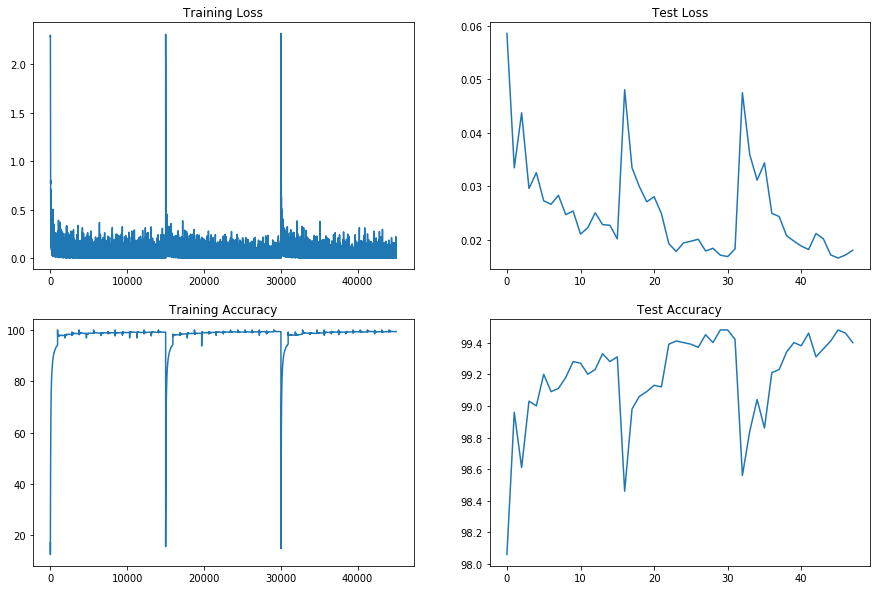

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")